In [1]:
%matplotlib inline

import os
while 'source' not in os.listdir():
    os.chdir('..')
os.chdir('source')

FORCE = False

import gpu

In [2]:
from util import getHashId


props={
    'path'          : 'data',
    'seed'          : 42,
    'split'         : 0.8,
    'test_split'    : 0.5,
    'control'       : True,
    'huntington'    : False,
    'left'          : True,
    'right'         : True,
    'threshold'     : None,
    'binarize'      : False,
    'not_connected' : False,
    'single'        : None,
    'features'      : [],
    'features_vox'  : [],
    'radiomics'     : [
        {'sp':'native','im':'t1','fe':['b25'],'fi':['t1_mask']},
    ],
    'space'         : 'native',
    'radiomics_vox' : [
        {'im':'t1','fe':['k5_b25','k7_b25','k9_b25','k11_b25','k13_b25','k15_b25','k17_b25','k19_b25','k21_b25']},
    ],
    'rad_vox_norm'  : 'norm',
    'inps'          : [],
    'features_clin' : None,
    'outp'          : 'diffusion_md',
    'balance_data'  : False,
    'exclude'       : ['t1t2','normalized'],
    'include_warp'  : True,
    'collapse_max'  : False,
    'collapse_bin'  : False,
}

architecture={
    'activation'    : 'sigmoid',
    'layers'        : [1024,512,256,128],
    'loss'          : 'MSE',
    'learning_rate' : 0.001,
    'batch_size'    : 1000,
    'patience'      : 4,
    'dropout'       : 0.75,
}

HASHID, HASH = getHashId(architecture,props)
print(HASH)

sigmoid_1000_075_1024_512_256_128_0001_MSE_4_0_0_0_0_1_t1t2_normalized_e_n_e_0_1_e_1_0_diffusion_md_data_norm_b25_t1_mask_t1_native_k5_b25_k7_b25_k9_b25_k11_b25_k13_b25_k15_b25_k17_b25_k19_b25_k21_b25_t1_1_42_n_native_08_05_n


In [3]:
from DataGenerator import DataGenerator

gen = DataGenerator(**props)
train, val, test = gen.getData()

print('train')
print(train[0].shape)
print(train[1].shape)
print('validation')
print(val[0].shape)
print(val[1].shape)
print('test')
print(test[0].shape)
print(test[1].shape)

train
(631390, 934)
(631390, 1)
validation
(74368, 934)
(74368, 1)
test
(85358, 934)
(85358, 1)


In [4]:
from Model import *
from tensorflow.keras.optimizers import Adam

path = props['path']+'/models'

stop = tf.keras.callbacks.EarlyStopping(
    monitor='val_loss',
    patience=architecture['patience'],
)
save = tf.keras.callbacks.ModelCheckpoint(
    filepath=path+'/{}.weights.h5'.format(HASHID),
    monitor='val_loss',
    mode='min',
    save_best_only=True,
    save_weights_only=True,
)

model = buildModel(train[0].shape[1], train[1].shape[1], activation=architecture['activation'], layers=architecture['layers'])

model.compile(loss=locals()[architecture['loss']], optimizer=Adam(learning_rate=architecture['learning_rate']), jit_compile=True, metrics=[STD,MAE])

model.summary()

Model: "FFN"


_________________________________________________________________


 Layer (type)                Output Shape              Param #   


 input_1 (InputLayer)        [(None, 934)]             0         


 dense (Dense)               (None, 1024)              957440    


 dense_1 (Dense)             (None, 512)               524800    


 dense_2 (Dense)             (None, 256)               131328    


 dense_3 (Dense)             (None, 128)               32896     


 dense_4 (Dense)             (None, 1)                 129       


Total params: 1646593 (6.28 MB)


Trainable params: 1646593 (6.28 MB)


Non-trainable params: 0 (0.00 Byte)


_________________________________________________________________


In [5]:
import os
from util import pickleSave

if FORCE or not os.path.exists(path+'/{}.pkl'.format(HASHID)):
    history = model.fit(DataWrapper(train,architecture['batch_size']),
        validation_data=DataWrapper(val,architecture['batch_size'],False),
        epochs=10000,
        verbose=1,
        callbacks = [save,stop],
    )
    pickleSave(path+'/{}.pkl'.format(HASHID), history.history)

model.load_weights(path+'/{}.weights.h5'.format(HASHID))

Epoch 1/10000


  1/632 [..............................] - ETA: 11:45 - loss: 0.0106 - STD: 2.1568e-04 - MAE: 0.0558

 12/632 [..............................] - ETA: 3s - loss: 0.0192 - STD: 0.0013 - MAE: 0.0977       

 22/632 [>.............................] - ETA: 3s - loss: 0.0171 - STD: 0.0019 - MAE: 0.0868

 32/632 [>.............................] - ETA: 3s - loss: 0.0157 - STD: 0.0028 - MAE: 0.0835

 43/632 [=>............................] - ETA: 3s - loss: 0.0146 - STD: 0.0051 - MAE: 0.0787

 55/632 [=>............................] - ETA: 2s - loss: 0.0133 - STD: 0.0124 - MAE: 0.0737

 67/632 [==>...........................] - ETA: 2s - loss: 0.0117 - STD: 0.0241 - MAE: 0.0684

 79/632 [==>...........................] - ETA: 2s - loss: 0.0105 - STD: 0.0346 - MAE: 0.0639

 92/632 [===>..........................] - ETA: 2s - loss: 0.0095 - STD: 0.0432 - MAE: 0.0601

104/632 [===>..........................] - ETA: 2s - loss: 0.0088 - STD: 0.0493 - MAE: 0.0572

116/632 [====>.........................] - ETA: 2s - loss: 0.0082 - STD: 0.0542 - MAE: 0.0549

118/632 [====>.........................] - ETA: 4s - loss: 0.0081 - STD: 0.0549 - MAE: 0.0546

130/632 [=====>........................] - ETA: 4s - loss: 0.0076 - STD: 0.0587 - MAE: 0.0527

140/632 [=====>........................] - ETA: 4s - loss: 0.0073 - STD: 0.0617 - MAE: 0.0514

151/632 [======>.......................] - ETA: 4s - loss: 0.0069 - STD: 0.0645 - MAE: 0.0501

163/632 [======>.......................] - ETA: 3s - loss: 0.0066 - STD: 0.0670 - MAE: 0.0487

175/632 [=======>......................] - ETA: 3s - loss: 0.0063 - STD: 0.0693 - MAE: 0.0476

187/632 [=======>......................] - ETA: 3s - loss: 0.0060 - STD: 0.0714 - MAE: 0.0465

199/632 [========>.....................] - ETA: 3s - loss: 0.0058 - STD: 0.0732 - MAE: 0.0456

211/632 [=========>....................] - ETA: 3s - loss: 0.0056 - STD: 0.0748 - MAE: 0.0448

223/632 [=========>....................] - ETA: 2s - loss: 0.0054 - STD: 0.0762 - MAE: 0.0440

235/632 [==========>...................] - ETA: 2s - loss: 0.0052 - STD: 0.0777 - MAE: 0.0433

247/632 [==========>...................] - ETA: 2s - loss: 0.0050 - STD: 0.0790 - MAE: 0.0427

260/632 [===========>..................] - ETA: 2s - loss: 0.0049 - STD: 0.0802 - MAE: 0.0421

272/632 [===========>..................] - ETA: 2s - loss: 0.0048 - STD: 0.0812 - MAE: 0.0415

284/632 [============>.................] - ETA: 2s - loss: 0.0046 - STD: 0.0820 - MAE: 0.0410

297/632 [=============>................] - ETA: 2s - loss: 0.0045 - STD: 0.0829 - MAE: 0.0404

310/632 [=============>................] - ETA: 2s - loss: 0.0044 - STD: 0.0839 - MAE: 0.0400

323/632 [==============>...............] - ETA: 1s - loss: 0.0043 - STD: 0.0847 - MAE: 0.0396

336/632 [==============>...............] - ETA: 1s - loss: 0.0042 - STD: 0.0854 - MAE: 0.0391

349/632 [===============>..............] - ETA: 1s - loss: 0.0041 - STD: 0.0862 - MAE: 0.0388

361/632 [================>.............] - ETA: 1s - loss: 0.0040 - STD: 0.0868 - MAE: 0.0384

372/632 [================>.............] - ETA: 1s - loss: 0.0040 - STD: 0.0872 - MAE: 0.0381

383/632 [=================>............] - ETA: 1s - loss: 0.0039 - STD: 0.0877 - MAE: 0.0379

394/632 [=================>............] - ETA: 1s - loss: 0.0038 - STD: 0.0882 - MAE: 0.0376

404/632 [==================>...........] - ETA: 1s - loss: 0.0038 - STD: 0.0887 - MAE: 0.0374

415/632 [==================>...........] - ETA: 1s - loss: 0.0037 - STD: 0.0892 - MAE: 0.0371

427/632 [===================>..........] - ETA: 1s - loss: 0.0037 - STD: 0.0897 - MAE: 0.0368

439/632 [===================>..........] - ETA: 1s - loss: 0.0036 - STD: 0.0900 - MAE: 0.0366

451/632 [====================>.........] - ETA: 1s - loss: 0.0036 - STD: 0.0903 - MAE: 0.0364

463/632 [====================>.........] - ETA: 0s - loss: 0.0035 - STD: 0.0906 - MAE: 0.0362

474/632 [=====================>........] - ETA: 0s - loss: 0.0035 - STD: 0.0910 - MAE: 0.0360

486/632 [======================>.......] - ETA: 0s - loss: 0.0034 - STD: 0.0913 - MAE: 0.0358

498/632 [======================>.......] - ETA: 0s - loss: 0.0034 - STD: 0.0916 - MAE: 0.0356

510/632 [=======================>......] - ETA: 0s - loss: 0.0033 - STD: 0.0920 - MAE: 0.0354

522/632 [=======================>......] - ETA: 0s - loss: 0.0033 - STD: 0.0923 - MAE: 0.0352

534/632 [========================>.....] - ETA: 0s - loss: 0.0033 - STD: 0.0926 - MAE: 0.0350

546/632 [========================>.....] - ETA: 0s - loss: 0.0032 - STD: 0.0929 - MAE: 0.0349

558/632 [=========================>....] - ETA: 0s - loss: 0.0032 - STD: 0.0931 - MAE: 0.0347

569/632 [==========================>...] - ETA: 0s - loss: 0.0032 - STD: 0.0934 - MAE: 0.0346

581/632 [==========================>...] - ETA: 0s - loss: 0.0031 - STD: 0.0936 - MAE: 0.0345

593/632 [===========================>..] - ETA: 0s - loss: 0.0031 - STD: 0.0938 - MAE: 0.0343

605/632 [===========================>..] - ETA: 0s - loss: 0.0031 - STD: 0.0941 - MAE: 0.0342

617/632 [============================>.] - ETA: 0s - loss: 0.0030 - STD: 0.0943 - MAE: 0.0341

629/632 [============================>.] - ETA: 0s - loss: 0.0030 - STD: 0.0944 - MAE: 0.0340

632/632 [==============================] - 5s 6ms/step - loss: 0.0030 - STD: 0.0944 - MAE: 0.0339 - val_loss: 0.0020 - val_STD: 0.0817 - val_MAE: 0.0308


Epoch 2/10000


  1/632 [..............................] - ETA: 12s - loss: 0.0015 - STD: 0.1083 - MAE: 0.0267

 12/632 [..............................] - ETA: 3s - loss: 0.0016 - STD: 0.1052 - MAE: 0.0270 

 24/632 [>.............................] - ETA: 2s - loss: 0.0015 - STD: 0.1058 - MAE: 0.0268

 36/632 [>.............................] - ETA: 2s - loss: 0.0016 - STD: 0.1049 - MAE: 0.0273

 48/632 [=>............................] - ETA: 2s - loss: 0.0015 - STD: 0.1056 - MAE: 0.0272

 60/632 [=>............................] - ETA: 2s - loss: 0.0015 - STD: 0.1053 - MAE: 0.0272

 72/632 [==>...........................] - ETA: 2s - loss: 0.0016 - STD: 0.1053 - MAE: 0.0272

 84/632 [==>...........................] - ETA: 2s - loss: 0.0016 - STD: 0.1056 - MAE: 0.0275

 96/632 [===>..........................] - ETA: 2s - loss: 0.0016 - STD: 0.1053 - MAE: 0.0278

108/632 [====>.........................] - ETA: 2s - loss: 0.0016 - STD: 0.1052 - MAE: 0.0278

120/632 [====>.........................] - ETA: 2s - loss: 0.0016 - STD: 0.1050 - MAE: 0.0278

132/632 [=====>........................] - ETA: 2s - loss: 0.0016 - STD: 0.1048 - MAE: 0.0278

144/632 [=====>........................] - ETA: 2s - loss: 0.0016 - STD: 0.1050 - MAE: 0.0277

156/632 [======>.......................] - ETA: 2s - loss: 0.0016 - STD: 0.1050 - MAE: 0.0276

168/632 [======>.......................] - ETA: 2s - loss: 0.0016 - STD: 0.1050 - MAE: 0.0276

180/632 [=======>......................] - ETA: 1s - loss: 0.0016 - STD: 0.1049 - MAE: 0.0277

192/632 [========>.....................] - ETA: 1s - loss: 0.0016 - STD: 0.1050 - MAE: 0.0278

204/632 [========>.....................] - ETA: 1s - loss: 0.0016 - STD: 0.1050 - MAE: 0.0277

216/632 [=========>....................] - ETA: 1s - loss: 0.0016 - STD: 0.1050 - MAE: 0.0277

228/632 [=========>....................] - ETA: 1s - loss: 0.0016 - STD: 0.1049 - MAE: 0.0277

240/632 [==========>...................] - ETA: 1s - loss: 0.0016 - STD: 0.1048 - MAE: 0.0276

252/632 [==========>...................] - ETA: 1s - loss: 0.0016 - STD: 0.1049 - MAE: 0.0276

264/632 [===========>..................] - ETA: 1s - loss: 0.0016 - STD: 0.1049 - MAE: 0.0276

276/632 [============>.................] - ETA: 1s - loss: 0.0016 - STD: 0.1048 - MAE: 0.0276

288/632 [============>.................] - ETA: 1s - loss: 0.0016 - STD: 0.1049 - MAE: 0.0276

300/632 [=============>................] - ETA: 1s - loss: 0.0016 - STD: 0.1049 - MAE: 0.0275

312/632 [=============>................] - ETA: 1s - loss: 0.0016 - STD: 0.1050 - MAE: 0.0275

324/632 [==============>...............] - ETA: 1s - loss: 0.0016 - STD: 0.1050 - MAE: 0.0275

337/632 [==============>...............] - ETA: 1s - loss: 0.0016 - STD: 0.1049 - MAE: 0.0274

349/632 [===============>..............] - ETA: 1s - loss: 0.0016 - STD: 0.1050 - MAE: 0.0274

361/632 [================>.............] - ETA: 1s - loss: 0.0016 - STD: 0.1049 - MAE: 0.0274

373/632 [================>.............] - ETA: 1s - loss: 0.0016 - STD: 0.1050 - MAE: 0.0274

385/632 [=================>............] - ETA: 1s - loss: 0.0016 - STD: 0.1050 - MAE: 0.0274

397/632 [=================>............] - ETA: 1s - loss: 0.0016 - STD: 0.1050 - MAE: 0.0273

409/632 [==================>...........] - ETA: 0s - loss: 0.0016 - STD: 0.1050 - MAE: 0.0273

421/632 [==================>...........] - ETA: 0s - loss: 0.0016 - STD: 0.1049 - MAE: 0.0273

432/632 [===================>..........] - ETA: 0s - loss: 0.0016 - STD: 0.1050 - MAE: 0.0273

444/632 [====================>.........] - ETA: 0s - loss: 0.0016 - STD: 0.1050 - MAE: 0.0272

456/632 [====================>.........] - ETA: 0s - loss: 0.0016 - STD: 0.1050 - MAE: 0.0273

468/632 [=====================>........] - ETA: 0s - loss: 0.0016 - STD: 0.1051 - MAE: 0.0272

480/632 [=====================>........] - ETA: 0s - loss: 0.0016 - STD: 0.1050 - MAE: 0.0272

492/632 [======================>.......] - ETA: 0s - loss: 0.0016 - STD: 0.1050 - MAE: 0.0272

504/632 [======================>.......] - ETA: 0s - loss: 0.0016 - STD: 0.1051 - MAE: 0.0272

516/632 [=======================>......] - ETA: 0s - loss: 0.0016 - STD: 0.1051 - MAE: 0.0272

528/632 [========================>.....] - ETA: 0s - loss: 0.0016 - STD: 0.1051 - MAE: 0.0272

540/632 [========================>.....] - ETA: 0s - loss: 0.0016 - STD: 0.1051 - MAE: 0.0272

552/632 [=========================>....] - ETA: 0s - loss: 0.0016 - STD: 0.1051 - MAE: 0.0272

564/632 [=========================>....] - ETA: 0s - loss: 0.0016 - STD: 0.1051 - MAE: 0.0273

576/632 [==========================>...] - ETA: 0s - loss: 0.0016 - STD: 0.1051 - MAE: 0.0273

588/632 [==========================>...] - ETA: 0s - loss: 0.0016 - STD: 0.1052 - MAE: 0.0273

600/632 [===========================>..] - ETA: 0s - loss: 0.0016 - STD: 0.1052 - MAE: 0.0272

612/632 [============================>.] - ETA: 0s - loss: 0.0016 - STD: 0.1052 - MAE: 0.0272

624/632 [============================>.] - ETA: 0s - loss: 0.0016 - STD: 0.1052 - MAE: 0.0272

632/632 [==============================] - 3s 5ms/step - loss: 0.0016 - STD: 0.1052 - MAE: 0.0272 - val_loss: 0.0015 - val_STD: 0.0768 - val_MAE: 0.0278


Epoch 3/10000


  1/632 [..............................] - ETA: 12s - loss: 0.0016 - STD: 0.0941 - MAE: 0.0278

 11/632 [..............................] - ETA: 3s - loss: 0.0015 - STD: 0.1039 - MAE: 0.0270 

 22/632 [>.............................] - ETA: 3s - loss: 0.0015 - STD: 0.1046 - MAE: 0.0270

 34/632 [>.............................] - ETA: 2s - loss: 0.0015 - STD: 0.1053 - MAE: 0.0270

 46/632 [=>............................] - ETA: 2s - loss: 0.0015 - STD: 0.1050 - MAE: 0.0268

 58/632 [=>............................] - ETA: 2s - loss: 0.0015 - STD: 0.1052 - MAE: 0.0266

 70/632 [==>...........................] - ETA: 2s - loss: 0.0015 - STD: 0.1054 - MAE: 0.0265

 82/632 [==>...........................] - ETA: 2s - loss: 0.0015 - STD: 0.1051 - MAE: 0.0265

 94/632 [===>..........................] - ETA: 2s - loss: 0.0015 - STD: 0.1052 - MAE: 0.0265

106/632 [====>.........................] - ETA: 2s - loss: 0.0015 - STD: 0.1053 - MAE: 0.0265

118/632 [====>.........................] - ETA: 2s - loss: 0.0015 - STD: 0.1053 - MAE: 0.0264

130/632 [=====>........................] - ETA: 2s - loss: 0.0015 - STD: 0.1052 - MAE: 0.0265

143/632 [=====>........................] - ETA: 2s - loss: 0.0015 - STD: 0.1052 - MAE: 0.0266

156/632 [======>.......................] - ETA: 2s - loss: 0.0015 - STD: 0.1054 - MAE: 0.0265

168/632 [======>.......................] - ETA: 2s - loss: 0.0015 - STD: 0.1053 - MAE: 0.0265

180/632 [=======>......................] - ETA: 1s - loss: 0.0015 - STD: 0.1053 - MAE: 0.0265

192/632 [========>.....................] - ETA: 1s - loss: 0.0015 - STD: 0.1053 - MAE: 0.0265

204/632 [========>.....................] - ETA: 1s - loss: 0.0015 - STD: 0.1053 - MAE: 0.0265

216/632 [=========>....................] - ETA: 1s - loss: 0.0015 - STD: 0.1053 - MAE: 0.0265

228/632 [=========>....................] - ETA: 1s - loss: 0.0015 - STD: 0.1055 - MAE: 0.0264

240/632 [==========>...................] - ETA: 1s - loss: 0.0015 - STD: 0.1056 - MAE: 0.0265

253/632 [===========>..................] - ETA: 1s - loss: 0.0015 - STD: 0.1056 - MAE: 0.0264

265/632 [===========>..................] - ETA: 1s - loss: 0.0015 - STD: 0.1055 - MAE: 0.0264

277/632 [============>.................] - ETA: 1s - loss: 0.0015 - STD: 0.1055 - MAE: 0.0265

290/632 [============>.................] - ETA: 1s - loss: 0.0015 - STD: 0.1055 - MAE: 0.0264

302/632 [=============>................] - ETA: 1s - loss: 0.0015 - STD: 0.1056 - MAE: 0.0264

314/632 [=============>................] - ETA: 1s - loss: 0.0015 - STD: 0.1056 - MAE: 0.0264

326/632 [==============>...............] - ETA: 1s - loss: 0.0015 - STD: 0.1056 - MAE: 0.0264

339/632 [===============>..............] - ETA: 1s - loss: 0.0015 - STD: 0.1056 - MAE: 0.0265

351/632 [===============>..............] - ETA: 1s - loss: 0.0015 - STD: 0.1056 - MAE: 0.0265

363/632 [================>.............] - ETA: 1s - loss: 0.0015 - STD: 0.1056 - MAE: 0.0265

375/632 [================>.............] - ETA: 1s - loss: 0.0015 - STD: 0.1056 - MAE: 0.0264

387/632 [=================>............] - ETA: 1s - loss: 0.0015 - STD: 0.1056 - MAE: 0.0264

399/632 [=================>............] - ETA: 1s - loss: 0.0015 - STD: 0.1056 - MAE: 0.0265

411/632 [==================>...........] - ETA: 0s - loss: 0.0015 - STD: 0.1056 - MAE: 0.0264

423/632 [===================>..........] - ETA: 0s - loss: 0.0015 - STD: 0.1056 - MAE: 0.0264

435/632 [===================>..........] - ETA: 0s - loss: 0.0015 - STD: 0.1056 - MAE: 0.0264

447/632 [====================>.........] - ETA: 0s - loss: 0.0015 - STD: 0.1056 - MAE: 0.0264

459/632 [====================>.........] - ETA: 0s - loss: 0.0015 - STD: 0.1056 - MAE: 0.0264

471/632 [=====================>........] - ETA: 0s - loss: 0.0015 - STD: 0.1055 - MAE: 0.0264

483/632 [=====================>........] - ETA: 0s - loss: 0.0015 - STD: 0.1055 - MAE: 0.0264

495/632 [======================>.......] - ETA: 0s - loss: 0.0015 - STD: 0.1055 - MAE: 0.0264

507/632 [=======================>......] - ETA: 0s - loss: 0.0015 - STD: 0.1055 - MAE: 0.0264

519/632 [=======================>......] - ETA: 0s - loss: 0.0015 - STD: 0.1055 - MAE: 0.0264

531/632 [========================>.....] - ETA: 0s - loss: 0.0015 - STD: 0.1056 - MAE: 0.0264

543/632 [========================>.....] - ETA: 0s - loss: 0.0015 - STD: 0.1056 - MAE: 0.0264

555/632 [=========================>....] - ETA: 0s - loss: 0.0015 - STD: 0.1055 - MAE: 0.0264

567/632 [=========================>....] - ETA: 0s - loss: 0.0015 - STD: 0.1055 - MAE: 0.0264

579/632 [==========================>...] - ETA: 0s - loss: 0.0015 - STD: 0.1056 - MAE: 0.0264

591/632 [===========================>..] - ETA: 0s - loss: 0.0015 - STD: 0.1056 - MAE: 0.0264

603/632 [===========================>..] - ETA: 0s - loss: 0.0015 - STD: 0.1056 - MAE: 0.0264

615/632 [============================>.] - ETA: 0s - loss: 0.0015 - STD: 0.1057 - MAE: 0.0264

627/632 [============================>.] - ETA: 0s - loss: 0.0015 - STD: 0.1056 - MAE: 0.0264

632/632 [==============================] - 3s 5ms/step - loss: 0.0015 - STD: 0.1057 - MAE: 0.0264 - val_loss: 0.0015 - val_STD: 0.0797 - val_MAE: 0.0277


Epoch 4/10000


  1/632 [..............................] - ETA: 14s - loss: 0.0013 - STD: 0.1042 - MAE: 0.0249

 12/632 [..............................] - ETA: 2s - loss: 0.0014 - STD: 0.1046 - MAE: 0.0258 

 22/632 [>.............................] - ETA: 3s - loss: 0.0015 - STD: 0.1047 - MAE: 0.0265

 33/632 [>.............................] - ETA: 2s - loss: 0.0016 - STD: 0.1043 - MAE: 0.0272

 43/632 [=>............................] - ETA: 2s - loss: 0.0016 - STD: 0.1048 - MAE: 0.0273

 53/632 [=>............................] - ETA: 2s - loss: 0.0015 - STD: 0.1051 - MAE: 0.0270

 64/632 [==>...........................] - ETA: 2s - loss: 0.0015 - STD: 0.1049 - MAE: 0.0268

 76/632 [==>...........................] - ETA: 2s - loss: 0.0015 - STD: 0.1048 - MAE: 0.0268

 86/632 [===>..........................] - ETA: 2s - loss: 0.0015 - STD: 0.1050 - MAE: 0.0268

 97/632 [===>..........................] - ETA: 2s - loss: 0.0015 - STD: 0.1051 - MAE: 0.0267

109/632 [====>.........................] - ETA: 2s - loss: 0.0015 - STD: 0.1052 - MAE: 0.0266

121/632 [====>.........................] - ETA: 2s - loss: 0.0015 - STD: 0.1051 - MAE: 0.0265

133/632 [=====>........................] - ETA: 2s - loss: 0.0015 - STD: 0.1052 - MAE: 0.0265

145/632 [=====>........................] - ETA: 2s - loss: 0.0015 - STD: 0.1050 - MAE: 0.0265

157/632 [======>.......................] - ETA: 2s - loss: 0.0015 - STD: 0.1050 - MAE: 0.0265

168/632 [======>.......................] - ETA: 2s - loss: 0.0015 - STD: 0.1051 - MAE: 0.0265

181/632 [=======>......................] - ETA: 2s - loss: 0.0015 - STD: 0.1051 - MAE: 0.0264

192/632 [========>.....................] - ETA: 2s - loss: 0.0015 - STD: 0.1051 - MAE: 0.0264

203/632 [========>.....................] - ETA: 2s - loss: 0.0015 - STD: 0.1051 - MAE: 0.0265

215/632 [=========>....................] - ETA: 1s - loss: 0.0015 - STD: 0.1052 - MAE: 0.0264

227/632 [=========>....................] - ETA: 1s - loss: 0.0015 - STD: 0.1053 - MAE: 0.0264

239/632 [==========>...................] - ETA: 1s - loss: 0.0015 - STD: 0.1053 - MAE: 0.0264

251/632 [==========>...................] - ETA: 1s - loss: 0.0015 - STD: 0.1053 - MAE: 0.0264

263/632 [===========>..................] - ETA: 1s - loss: 0.0015 - STD: 0.1054 - MAE: 0.0264

275/632 [============>.................] - ETA: 1s - loss: 0.0015 - STD: 0.1054 - MAE: 0.0264

287/632 [============>.................] - ETA: 1s - loss: 0.0015 - STD: 0.1055 - MAE: 0.0263

300/632 [=============>................] - ETA: 1s - loss: 0.0014 - STD: 0.1054 - MAE: 0.0263

312/632 [=============>................] - ETA: 1s - loss: 0.0014 - STD: 0.1055 - MAE: 0.0263

324/632 [==============>...............] - ETA: 1s - loss: 0.0014 - STD: 0.1056 - MAE: 0.0262

336/632 [==============>...............] - ETA: 1s - loss: 0.0014 - STD: 0.1056 - MAE: 0.0262

348/632 [===============>..............] - ETA: 1s - loss: 0.0014 - STD: 0.1056 - MAE: 0.0263

360/632 [================>.............] - ETA: 1s - loss: 0.0014 - STD: 0.1057 - MAE: 0.0263

372/632 [================>.............] - ETA: 1s - loss: 0.0014 - STD: 0.1056 - MAE: 0.0262

384/632 [=================>............] - ETA: 1s - loss: 0.0014 - STD: 0.1057 - MAE: 0.0262

394/632 [=================>............] - ETA: 1s - loss: 0.0014 - STD: 0.1056 - MAE: 0.0262

405/632 [==================>...........] - ETA: 1s - loss: 0.0014 - STD: 0.1056 - MAE: 0.0262

417/632 [==================>...........] - ETA: 0s - loss: 0.0014 - STD: 0.1057 - MAE: 0.0262

428/632 [===================>..........] - ETA: 0s - loss: 0.0014 - STD: 0.1057 - MAE: 0.0262

438/632 [===================>..........] - ETA: 0s - loss: 0.0014 - STD: 0.1056 - MAE: 0.0262

448/632 [====================>.........] - ETA: 0s - loss: 0.0014 - STD: 0.1056 - MAE: 0.0262

460/632 [====================>.........] - ETA: 0s - loss: 0.0014 - STD: 0.1056 - MAE: 0.0262

472/632 [=====================>........] - ETA: 0s - loss: 0.0014 - STD: 0.1057 - MAE: 0.0262

485/632 [======================>.......] - ETA: 0s - loss: 0.0014 - STD: 0.1057 - MAE: 0.0262

496/632 [======================>.......] - ETA: 0s - loss: 0.0014 - STD: 0.1057 - MAE: 0.0262

506/632 [=======================>......] - ETA: 0s - loss: 0.0014 - STD: 0.1058 - MAE: 0.0262

516/632 [=======================>......] - ETA: 0s - loss: 0.0014 - STD: 0.1057 - MAE: 0.0261

526/632 [=======================>......] - ETA: 0s - loss: 0.0014 - STD: 0.1058 - MAE: 0.0261

536/632 [========================>.....] - ETA: 0s - loss: 0.0014 - STD: 0.1057 - MAE: 0.0262

546/632 [========================>.....] - ETA: 0s - loss: 0.0014 - STD: 0.1057 - MAE: 0.0262

557/632 [=========================>....] - ETA: 0s - loss: 0.0014 - STD: 0.1058 - MAE: 0.0262

568/632 [=========================>....] - ETA: 0s - loss: 0.0014 - STD: 0.1057 - MAE: 0.0262

578/632 [==========================>...] - ETA: 0s - loss: 0.0014 - STD: 0.1057 - MAE: 0.0262

589/632 [==========================>...] - ETA: 0s - loss: 0.0014 - STD: 0.1057 - MAE: 0.0262

600/632 [===========================>..] - ETA: 0s - loss: 0.0014 - STD: 0.1057 - MAE: 0.0261

610/632 [===========================>..] - ETA: 0s - loss: 0.0014 - STD: 0.1058 - MAE: 0.0261

620/632 [============================>.] - ETA: 0s - loss: 0.0014 - STD: 0.1058 - MAE: 0.0261

630/632 [============================>.] - ETA: 0s - loss: 0.0014 - STD: 0.1058 - MAE: 0.0261

632/632 [==============================] - 3s 5ms/step - loss: 0.0014 - STD: 0.1058 - MAE: 0.0261 - val_loss: 0.0015 - val_STD: 0.0805 - val_MAE: 0.0274


Epoch 5/10000


  1/632 [..............................] - ETA: 15s - loss: 0.0014 - STD: 0.1095 - MAE: 0.0258

 11/632 [..............................] - ETA: 3s - loss: 0.0014 - STD: 0.1046 - MAE: 0.0262 

 21/632 [..............................] - ETA: 3s - loss: 0.0014 - STD: 0.1057 - MAE: 0.0259

 31/632 [>.............................] - ETA: 3s - loss: 0.0014 - STD: 0.1069 - MAE: 0.0257

 41/632 [>.............................] - ETA: 3s - loss: 0.0014 - STD: 0.1065 - MAE: 0.0257

 51/632 [=>............................] - ETA: 3s - loss: 0.0014 - STD: 0.1067 - MAE: 0.0257

 61/632 [=>............................] - ETA: 2s - loss: 0.0014 - STD: 0.1070 - MAE: 0.0256

 71/632 [==>...........................] - ETA: 2s - loss: 0.0014 - STD: 0.1073 - MAE: 0.0257

 82/632 [==>...........................] - ETA: 2s - loss: 0.0014 - STD: 0.1067 - MAE: 0.0258

 93/632 [===>..........................] - ETA: 2s - loss: 0.0014 - STD: 0.1068 - MAE: 0.0257

104/632 [===>..........................] - ETA: 2s - loss: 0.0014 - STD: 0.1068 - MAE: 0.0257

114/632 [====>.........................] - ETA: 2s - loss: 0.0014 - STD: 0.1067 - MAE: 0.0257

124/632 [====>.........................] - ETA: 2s - loss: 0.0014 - STD: 0.1065 - MAE: 0.0258

134/632 [=====>........................] - ETA: 2s - loss: 0.0014 - STD: 0.1064 - MAE: 0.0259

144/632 [=====>........................] - ETA: 2s - loss: 0.0014 - STD: 0.1063 - MAE: 0.0259

154/632 [======>.......................] - ETA: 2s - loss: 0.0014 - STD: 0.1063 - MAE: 0.0260

165/632 [======>.......................] - ETA: 2s - loss: 0.0014 - STD: 0.1063 - MAE: 0.0260

175/632 [=======>......................] - ETA: 2s - loss: 0.0014 - STD: 0.1062 - MAE: 0.0260

186/632 [=======>......................] - ETA: 2s - loss: 0.0014 - STD: 0.1062 - MAE: 0.0260

197/632 [========>.....................] - ETA: 2s - loss: 0.0014 - STD: 0.1061 - MAE: 0.0260

207/632 [========>.....................] - ETA: 2s - loss: 0.0014 - STD: 0.1062 - MAE: 0.0260

217/632 [=========>....................] - ETA: 2s - loss: 0.0014 - STD: 0.1061 - MAE: 0.0261

229/632 [=========>....................] - ETA: 2s - loss: 0.0014 - STD: 0.1061 - MAE: 0.0261

241/632 [==========>...................] - ETA: 1s - loss: 0.0014 - STD: 0.1062 - MAE: 0.0261

253/632 [===========>..................] - ETA: 1s - loss: 0.0014 - STD: 0.1062 - MAE: 0.0261

265/632 [===========>..................] - ETA: 1s - loss: 0.0014 - STD: 0.1062 - MAE: 0.0261

277/632 [============>.................] - ETA: 1s - loss: 0.0014 - STD: 0.1062 - MAE: 0.0260

289/632 [============>.................] - ETA: 1s - loss: 0.0014 - STD: 0.1061 - MAE: 0.0260

301/632 [=============>................] - ETA: 1s - loss: 0.0014 - STD: 0.1062 - MAE: 0.0259

313/632 [=============>................] - ETA: 1s - loss: 0.0014 - STD: 0.1061 - MAE: 0.0259

325/632 [==============>...............] - ETA: 1s - loss: 0.0014 - STD: 0.1061 - MAE: 0.0259

337/632 [==============>...............] - ETA: 1s - loss: 0.0014 - STD: 0.1061 - MAE: 0.0259

349/632 [===============>..............] - ETA: 1s - loss: 0.0014 - STD: 0.1061 - MAE: 0.0259

361/632 [================>.............] - ETA: 1s - loss: 0.0014 - STD: 0.1062 - MAE: 0.0259

373/632 [================>.............] - ETA: 1s - loss: 0.0014 - STD: 0.1062 - MAE: 0.0259

385/632 [=================>............] - ETA: 1s - loss: 0.0014 - STD: 0.1062 - MAE: 0.0259

397/632 [=================>............] - ETA: 1s - loss: 0.0014 - STD: 0.1061 - MAE: 0.0259

409/632 [==================>...........] - ETA: 1s - loss: 0.0014 - STD: 0.1061 - MAE: 0.0259

421/632 [==================>...........] - ETA: 1s - loss: 0.0014 - STD: 0.1061 - MAE: 0.0258

433/632 [===================>..........] - ETA: 0s - loss: 0.0014 - STD: 0.1061 - MAE: 0.0258

445/632 [====================>.........] - ETA: 0s - loss: 0.0014 - STD: 0.1061 - MAE: 0.0258

457/632 [====================>.........] - ETA: 0s - loss: 0.0014 - STD: 0.1061 - MAE: 0.0258

469/632 [=====================>........] - ETA: 0s - loss: 0.0014 - STD: 0.1060 - MAE: 0.0258

481/632 [=====================>........] - ETA: 0s - loss: 0.0014 - STD: 0.1060 - MAE: 0.0258

492/632 [======================>.......] - ETA: 0s - loss: 0.0014 - STD: 0.1060 - MAE: 0.0257

504/632 [======================>.......] - ETA: 0s - loss: 0.0014 - STD: 0.1060 - MAE: 0.0257

516/632 [=======================>......] - ETA: 0s - loss: 0.0014 - STD: 0.1060 - MAE: 0.0257

527/632 [========================>.....] - ETA: 0s - loss: 0.0014 - STD: 0.1060 - MAE: 0.0257

539/632 [========================>.....] - ETA: 0s - loss: 0.0014 - STD: 0.1061 - MAE: 0.0257

551/632 [=========================>....] - ETA: 0s - loss: 0.0014 - STD: 0.1061 - MAE: 0.0257

563/632 [=========================>....] - ETA: 0s - loss: 0.0014 - STD: 0.1060 - MAE: 0.0256

575/632 [==========================>...] - ETA: 0s - loss: 0.0014 - STD: 0.1060 - MAE: 0.0256

587/632 [==========================>...] - ETA: 0s - loss: 0.0014 - STD: 0.1060 - MAE: 0.0256

599/632 [===========================>..] - ETA: 0s - loss: 0.0014 - STD: 0.1060 - MAE: 0.0256

611/632 [============================>.] - ETA: 0s - loss: 0.0014 - STD: 0.1061 - MAE: 0.0257

623/632 [============================>.] - ETA: 0s - loss: 0.0014 - STD: 0.1060 - MAE: 0.0257

632/632 [==============================] - 3s 5ms/step - loss: 0.0014 - STD: 0.1060 - MAE: 0.0257 - val_loss: 0.0022 - val_STD: 0.0866 - val_MAE: 0.0324


Epoch 6/10000


  1/632 [..............................] - ETA: 14s - loss: 0.0014 - STD: 0.1077 - MAE: 0.0262

 11/632 [..............................] - ETA: 3s - loss: 0.0013 - STD: 0.1081 - MAE: 0.0252 

 23/632 [>.............................] - ETA: 2s - loss: 0.0013 - STD: 0.1074 - MAE: 0.0250

 35/632 [>.............................] - ETA: 2s - loss: 0.0013 - STD: 0.1068 - MAE: 0.0252

 47/632 [=>............................] - ETA: 2s - loss: 0.0013 - STD: 0.1067 - MAE: 0.0253

 59/632 [=>............................] - ETA: 2s - loss: 0.0013 - STD: 0.1066 - MAE: 0.0253

 71/632 [==>...........................] - ETA: 2s - loss: 0.0013 - STD: 0.1068 - MAE: 0.0253

 83/632 [==>...........................] - ETA: 2s - loss: 0.0013 - STD: 0.1064 - MAE: 0.0253

 95/632 [===>..........................] - ETA: 2s - loss: 0.0013 - STD: 0.1066 - MAE: 0.0252

107/632 [====>.........................] - ETA: 2s - loss: 0.0013 - STD: 0.1068 - MAE: 0.0252

119/632 [====>.........................] - ETA: 2s - loss: 0.0013 - STD: 0.1068 - MAE: 0.0252

131/632 [=====>........................] - ETA: 2s - loss: 0.0013 - STD: 0.1069 - MAE: 0.0253

143/632 [=====>........................] - ETA: 2s - loss: 0.0013 - STD: 0.1070 - MAE: 0.0253

155/632 [======>.......................] - ETA: 2s - loss: 0.0013 - STD: 0.1070 - MAE: 0.0254

167/632 [======>.......................] - ETA: 2s - loss: 0.0013 - STD: 0.1068 - MAE: 0.0254

179/632 [=======>......................] - ETA: 2s - loss: 0.0013 - STD: 0.1067 - MAE: 0.0254

191/632 [========>.....................] - ETA: 1s - loss: 0.0013 - STD: 0.1067 - MAE: 0.0254

203/632 [========>.....................] - ETA: 1s - loss: 0.0013 - STD: 0.1068 - MAE: 0.0254

215/632 [=========>....................] - ETA: 1s - loss: 0.0013 - STD: 0.1067 - MAE: 0.0254

227/632 [=========>....................] - ETA: 1s - loss: 0.0014 - STD: 0.1066 - MAE: 0.0255

239/632 [==========>...................] - ETA: 1s - loss: 0.0014 - STD: 0.1065 - MAE: 0.0255

251/632 [==========>...................] - ETA: 1s - loss: 0.0014 - STD: 0.1064 - MAE: 0.0255

263/632 [===========>..................] - ETA: 1s - loss: 0.0013 - STD: 0.1065 - MAE: 0.0254

275/632 [============>.................] - ETA: 1s - loss: 0.0013 - STD: 0.1063 - MAE: 0.0254

287/632 [============>.................] - ETA: 1s - loss: 0.0013 - STD: 0.1063 - MAE: 0.0254

299/632 [=============>................] - ETA: 1s - loss: 0.0013 - STD: 0.1063 - MAE: 0.0253

311/632 [=============>................] - ETA: 1s - loss: 0.0013 - STD: 0.1063 - MAE: 0.0253

323/632 [==============>...............] - ETA: 1s - loss: 0.0013 - STD: 0.1063 - MAE: 0.0253

335/632 [==============>...............] - ETA: 1s - loss: 0.0013 - STD: 0.1062 - MAE: 0.0254

346/632 [===============>..............] - ETA: 1s - loss: 0.0013 - STD: 0.1062 - MAE: 0.0254

358/632 [===============>..............] - ETA: 1s - loss: 0.0013 - STD: 0.1062 - MAE: 0.0254

370/632 [================>.............] - ETA: 1s - loss: 0.0013 - STD: 0.1062 - MAE: 0.0254

382/632 [=================>............] - ETA: 1s - loss: 0.0013 - STD: 0.1063 - MAE: 0.0253

394/632 [=================>............] - ETA: 1s - loss: 0.0013 - STD: 0.1063 - MAE: 0.0253

405/632 [==================>...........] - ETA: 1s - loss: 0.0013 - STD: 0.1062 - MAE: 0.0253

417/632 [==================>...........] - ETA: 0s - loss: 0.0013 - STD: 0.1062 - MAE: 0.0253

429/632 [===================>..........] - ETA: 0s - loss: 0.0013 - STD: 0.1062 - MAE: 0.0252

440/632 [===================>..........] - ETA: 0s - loss: 0.0013 - STD: 0.1062 - MAE: 0.0252

450/632 [====================>.........] - ETA: 0s - loss: 0.0013 - STD: 0.1062 - MAE: 0.0252

462/632 [====================>.........] - ETA: 0s - loss: 0.0013 - STD: 0.1062 - MAE: 0.0252

474/632 [=====================>........] - ETA: 0s - loss: 0.0013 - STD: 0.1062 - MAE: 0.0252

486/632 [======================>.......] - ETA: 0s - loss: 0.0013 - STD: 0.1062 - MAE: 0.0252

498/632 [======================>.......] - ETA: 0s - loss: 0.0013 - STD: 0.1062 - MAE: 0.0252

509/632 [=======================>......] - ETA: 0s - loss: 0.0013 - STD: 0.1062 - MAE: 0.0252

521/632 [=======================>......] - ETA: 0s - loss: 0.0013 - STD: 0.1062 - MAE: 0.0252

533/632 [========================>.....] - ETA: 0s - loss: 0.0013 - STD: 0.1062 - MAE: 0.0252

545/632 [========================>.....] - ETA: 0s - loss: 0.0013 - STD: 0.1062 - MAE: 0.0252

556/632 [=========================>....] - ETA: 0s - loss: 0.0013 - STD: 0.1063 - MAE: 0.0252

568/632 [=========================>....] - ETA: 0s - loss: 0.0013 - STD: 0.1063 - MAE: 0.0252

580/632 [==========================>...] - ETA: 0s - loss: 0.0013 - STD: 0.1063 - MAE: 0.0251

592/632 [===========================>..] - ETA: 0s - loss: 0.0013 - STD: 0.1064 - MAE: 0.0251

602/632 [===========================>..] - ETA: 0s - loss: 0.0013 - STD: 0.1063 - MAE: 0.0251

614/632 [============================>.] - ETA: 0s - loss: 0.0013 - STD: 0.1064 - MAE: 0.0252

626/632 [============================>.] - ETA: 0s - loss: 0.0013 - STD: 0.1063 - MAE: 0.0252

632/632 [==============================] - 3s 5ms/step - loss: 0.0013 - STD: 0.1063 - MAE: 0.0252 - val_loss: 0.0021 - val_STD: 0.0864 - val_MAE: 0.0307


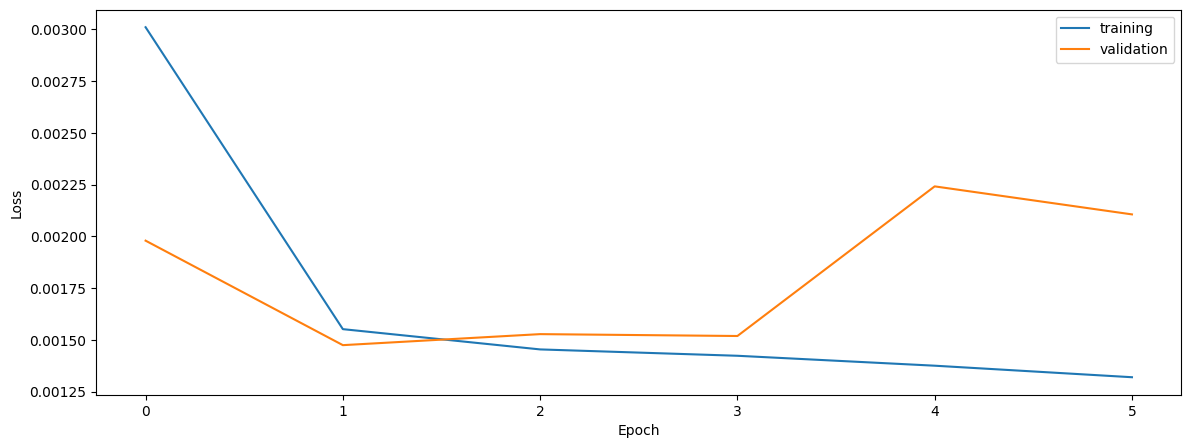

In [6]:
from util import pickleLoad
from visual import plotHistory

history = pickleLoad(path+'/{}.pkl'.format(HASHID))
plotHistory(history)

In [7]:
from util import getPearson, predictInBatches

train.append(predictInBatches(model,train[0],architecture['batch_size']))
val.append(predictInBatches(model,val[0],architecture['batch_size']))
test.append(predictInBatches(model,test[0],architecture['batch_size']))

print('train')
print(getPearson(train[1],train[4]))
print(getPearson(val[1],val[4]))
print(getPearson(test[1],test[4]))

train
0.9418079013791827
0.9549962910527586
0.949642588959653


In [8]:
print(props['space'])
print(getPearson(train[1],train[4],train[3][0]))
print(getPearson(val[1],val[4],val[3][0]))
print(getPearson(test[1],test[4],test[3][0]))

native
0.9428585065617869
0.9521851753833978
0.9502514624315599


In [9]:
print('normalized' if props['space'] == 'native' else 'native')
print(getPearson(train[1][train[2]],train[4][train[2]],train[3][1]))
print(getPearson(val[1][val[2]],val[4][val[2]],val[3][1]))
print(getPearson(test[1][test[2]],test[4][test[2]],test[3][1]))

normalized
0.9499298024471212
0.9543597828546683
0.9620310993541311


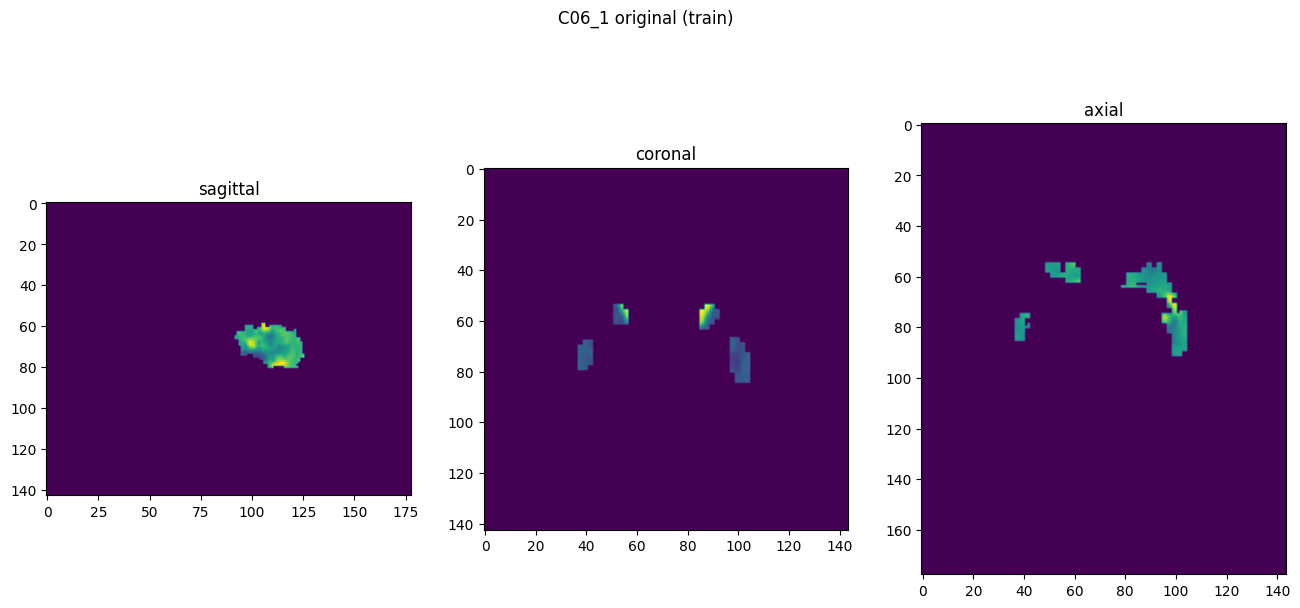

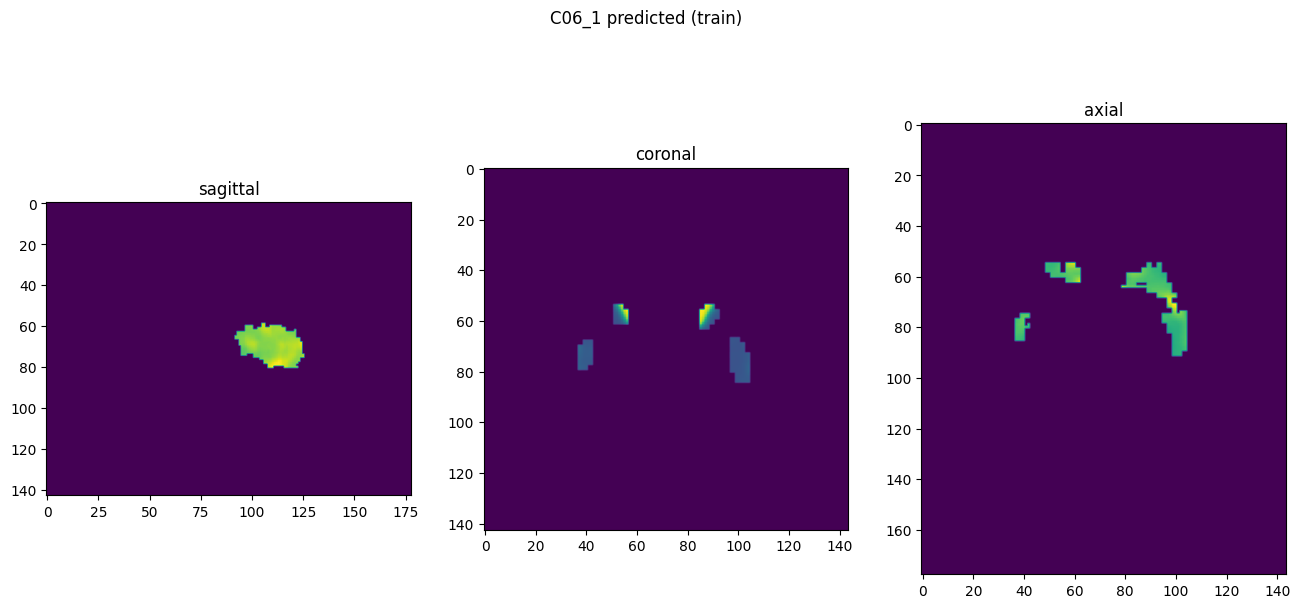

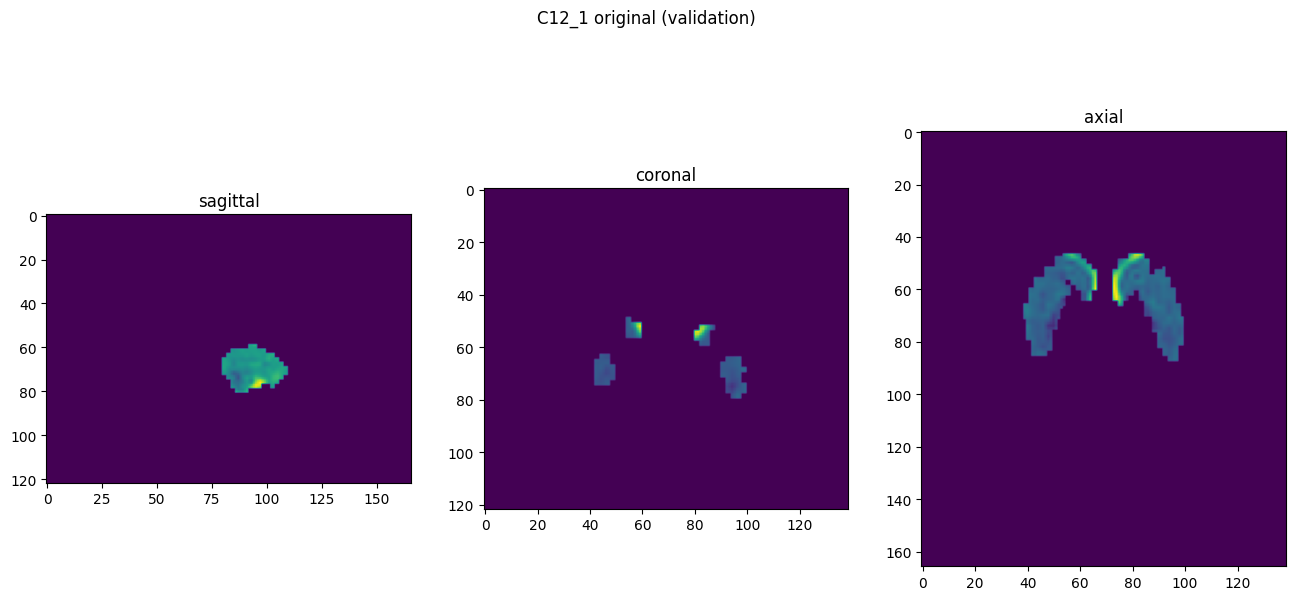

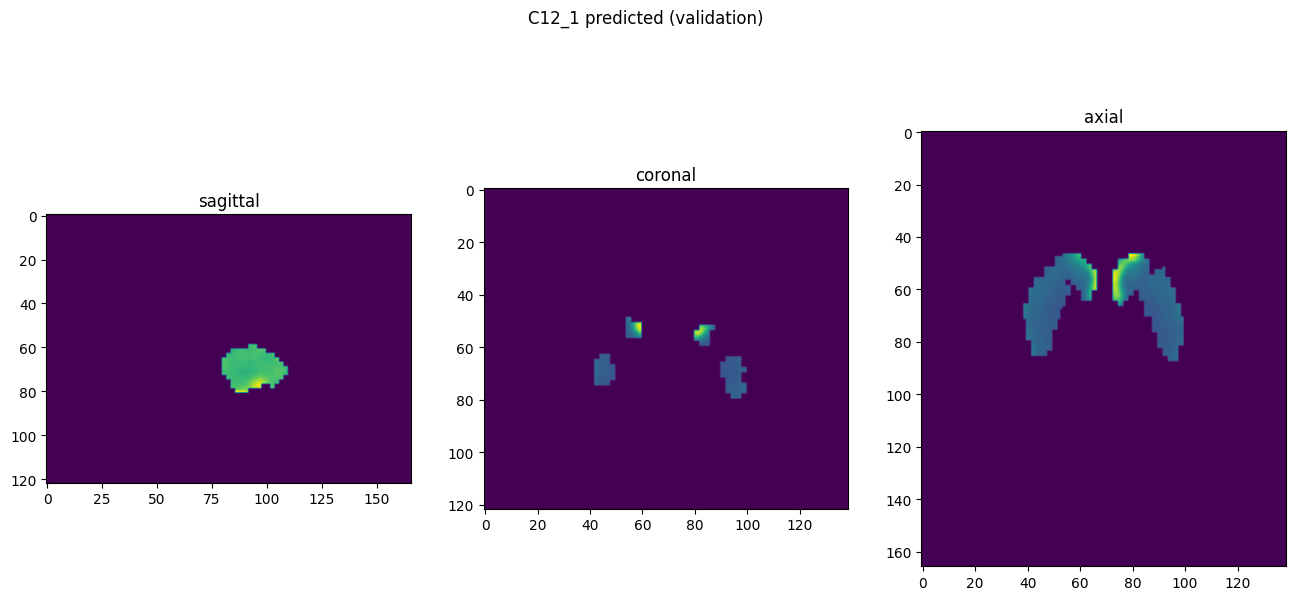

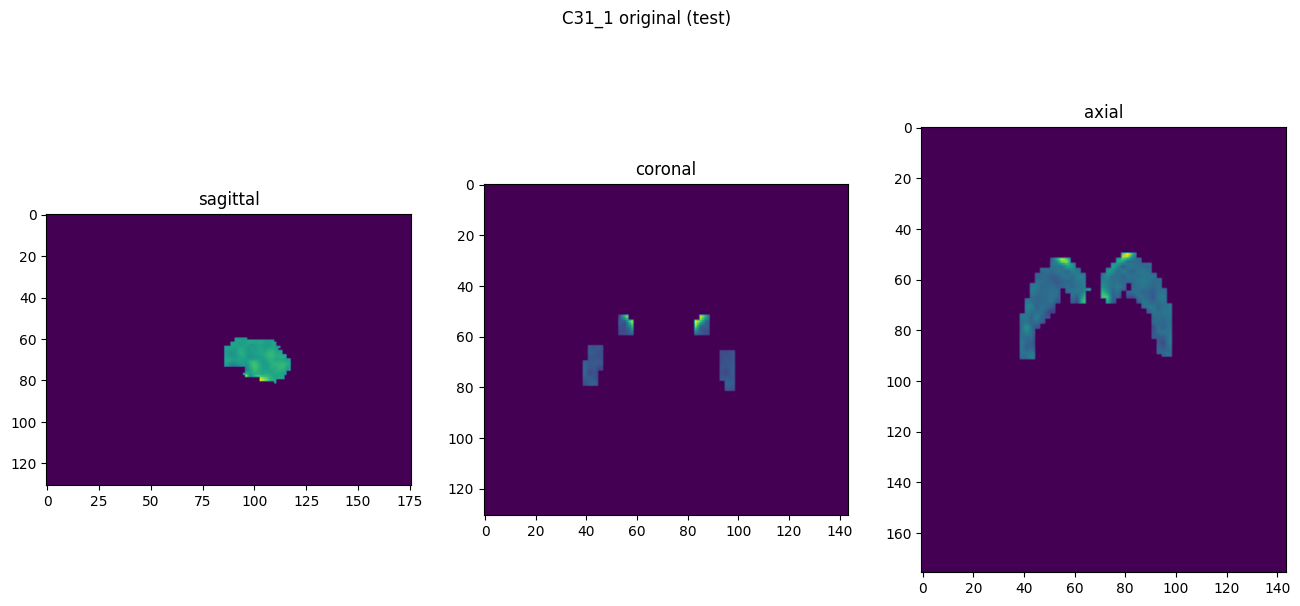

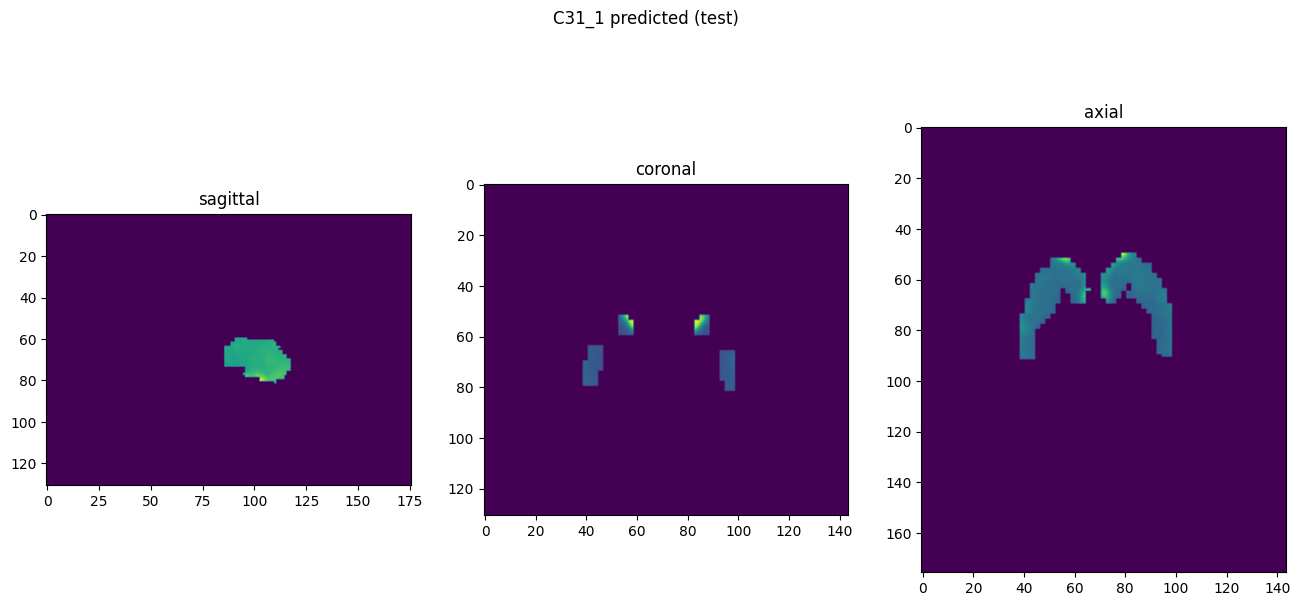

In [10]:
showResults(model, gen, threshold=None, background=False)